# Semantic Segmentation Lab
In this lab, you will build a deep learning network that locates a particular human target within an image.  The premise is that a quadcopter (simulated) is searching for a target, and then will follow the target once found.  It's not enough to simply say the target is present in the image in this case, but rather to know *where* in the image the target is, so that the copter can adjust its direction in order to follow.

Consequently, an image classification network is not enough to solve the problem. Instead, a semantic segmentation network is needed so that the target can be specifically located within the image.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with the dataset for this lab. If you haven't already downloaded the training and validation datasets, you can check out the README for this lab's repo for instructions as well.

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

#from tensorflow.contrib import keras
#from tensorflow.contrib.keras import layers, models
import tensorflow.contrib.keras as keras

from tensorflow import image

In [2]:
from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers<a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network. The following code will introduce you to the functions that you will be using to build out your model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers. Below we have implemented two functions - one which you can call upon to build out separable convolutions or regular convolutions. Each with batch normalization and with the ReLU activation function applied to the layers. 

While we recommend the use of separable convolutions thanks to their advantages we covered in the Classroom, some of the helper code we will present for your model will require the use for regular convolutions. But we encourage you to try and experiment with each as well!

The following will help you create the encoder block and the final model for your architecture.

In [5]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
#     output_layer = keras.layers.SeparableConv2D(filters=filters, kernel_size=3, strides=strides,
#                              padding='same', activation='relu')(input_layer)
    
    output_layer = keras.layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = keras.layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function will help implement the bilinear upsampling layer. Currently, upsampling by a factor of 2 is recommended but you can try out different factors as well. You will use this to create the decoder block later!

In [6]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model<a id='build'></a>
In the following cells, we will cover how to build the model for the task at hand. 

- We will first create an Encoder Block, where you will create a separable convolution layer using an input layer and the size(depth) of the filters as your inputs.
- Next, you will create the Decoder Block, where you will create an upsampling layer using bilinear upsampling, followed by a layer concatentaion, and some separable convolution layers.
- Finally, you will combine the above two and create the model. In this step you will be able to experiment with different number of layers and filter sizes for each to build your model.

Let's cover them individually below.

### Encoder Block
Below you will create a separable convolution layer using the separable_conv2d_batchnorm() function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [7]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block, as covered in the Classroom, comprises of three steps -

- A bilinear upsampling layer using the bilinear_upsample() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [62]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled_layer = bilinear_upsample(small_ip_layer)
    
    print('decoder_block:') 
    print(' * small: ', small_ip_layer)
    print(' * upsamled: ', upsampled_layer)
    print(' * large: ', large_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concatenated_layer = keras.layers.concatenate([upsampled_layer, large_ip_layer])
    print(' * concatenated_layer: ', concatenated_layer)
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(concatenated_layer, filters)
    
    print(' * output: ', output_layer)
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, you can go ahead and build your model architecture! 

There are three steps to the following:
- Add encoder blocks to build out initial set of layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add 1x1 Convolution layer using conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for upsampling and skip connections.

In [73]:
def fcn_model(inputs, num_classes):
    print('fcn_model:')
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    # エンコーダ―
    # エンコーダ層ごとに, モデルの delpth(フィルタ数)を増加させるのを忘れないで.
    encoded_layer = encoder_block(inputs, filters=16, strides=2)
    print(' : encoded_layer:', encoded_layer)
    encoded_layer2 = encoder_block(encoded_layer, filters=32, strides=2)
    print(' : -> encoded_layer2:', encoded_layer2)
    encoded_layer3 = encoder_block(encoded_layer2, filters=64, strides=2)
    print(' : -> encoded_layer3:', encoded_layer3)

    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    # 1x1 レイヤ
    layer_1x1 = conv2d_batchnorm(encoded_layer3, 128, kernel_size=1, strides=1)
    print(' : -> layer_1x1:', layer_1x1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    # デコーダー
    decoded_layer = decoder_block(layer_1x1, encoded_layer2, 64)
    print(' : -> decoded_layer:', decoded_layer)
    decoded_layer2 = decoder_block(decoded_layer, encoded_layer, 32)
    print(' : -> decoded_layer2:', decoded_layer2)
    decoded_layer3 = decoder_block(decoded_layer2, inputs, 16)
    print(' : -> decoded_layer3:', decoded_layer3)
    
    x = decoded_layer3
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return keras.layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

## Training<a id='training'></a>
The following cells will utilize the model you created and define an ouput layer based on the input and the number of classes.Following that you will define the hyperparameters to compile and train your model!

In [116]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 128
image_shape = (image_hw, image_hw, 3)
inputs = keras.layers.Input(image_shape)
num_classes = 3

print('inputs:', inputs)

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)
print('->output_layer:', output_layer) 

inputs: Tensor("input_19:0", shape=(?, 128, 128, 3), dtype=float32)
fcn_model:
 : encoded_layer: Tensor("batch_normalization_78/batchnorm/add_1:0", shape=(?, 64, 64, 16), dtype=float32)
 : -> encoded_layer2: Tensor("batch_normalization_79/batchnorm/add_1:0", shape=(?, 32, 32, 32), dtype=float32)
 : -> encoded_layer3: Tensor("batch_normalization_80/batchnorm/add_1:0", shape=(?, 16, 16, 64), dtype=float32)
 : -> layer_1x1: Tensor("batch_normalization_81/batchnorm/add_1:0", shape=(?, 16, 16, 128), dtype=float32)
decoder_block:
 * small:  Tensor("batch_normalization_81/batchnorm/add_1:0", shape=(?, 16, 16, 128), dtype=float32)
 * upsamled:  Tensor("bilinear_up_sampling2d_36/ResizeBilinear:0", shape=(?, 32, 32, 128), dtype=float32)
 * large:  Tensor("batch_normalization_79/batchnorm/add_1:0", shape=(?, 32, 32, 32), dtype=float32)
 * concatenated_layer:  Tensor("concatenate_36/concat:0", shape=(?, 32, 32, 160), dtype=float32)
 * output:  Tensor("batch_normalization_82/batchnorm/add_1:0", sha

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [100]:
learning_rate = 0.001
batch_size = 64
num_epochs = 50
steps_per_epoch = 30
validation_steps = 50
workers = 2

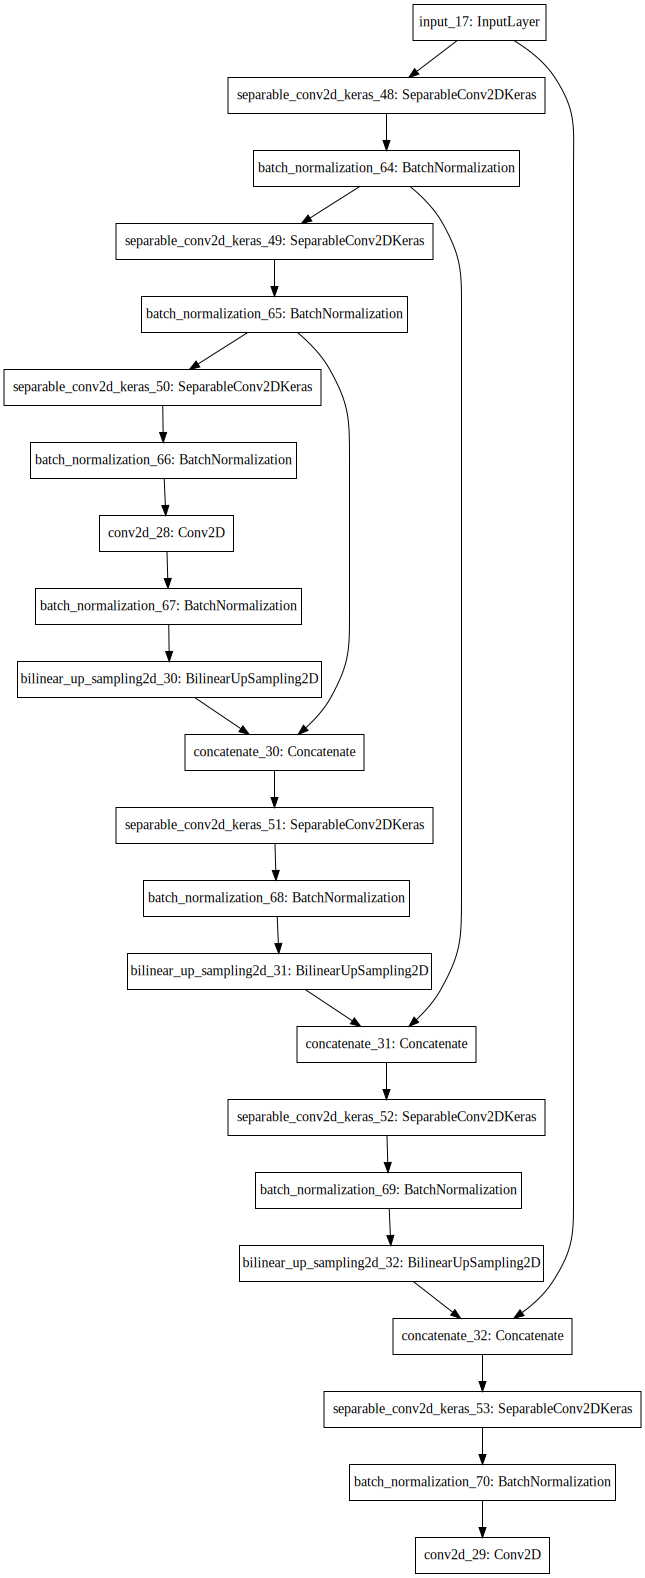

In [102]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = keras.models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# 可視化
## graphiz のインストールが必要
## Windows なら
##   $ scoop install graphviz
## そうでないなら
##   $ conda install graphviz
## 
## $ pip install pydot_ng
from tensorflow.contrib.keras.python.keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
SVG(model_to_dot(model).create(prog='dot', format='svg'))

Epoch 1/50
29/30 [============================>.] - ETA: 0s - loss: 1.1163

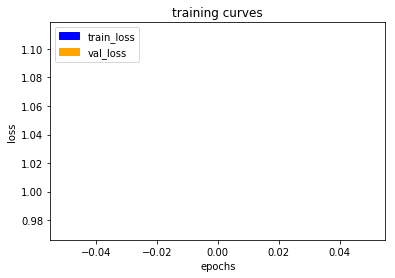

30/30 [==============================] - 23s - loss: 1.1117 - val_loss: 0.9731
Epoch 2/50
29/30 [============================>.] - ETA: 0s - loss: 0.8403

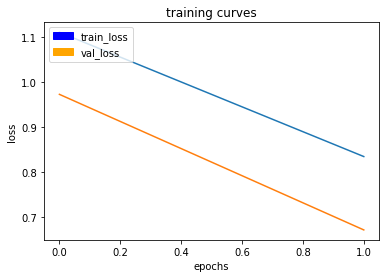

30/30 [==============================] - 21s - loss: 0.8345 - val_loss: 0.6708
Epoch 3/50
29/30 [============================>.] - ETA: 0s - loss: 0.4529

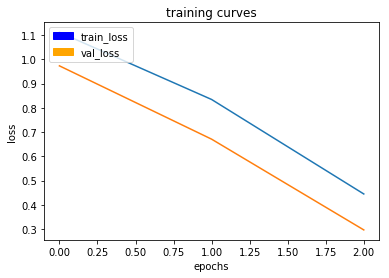

30/30 [==============================] - 22s - loss: 0.4469 - val_loss: 0.2967
Epoch 4/50
29/30 [============================>.] - ETA: 0s - loss: 0.1800

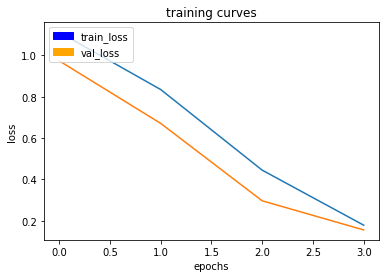

30/30 [==============================] - 22s - loss: 0.1790 - val_loss: 0.1560
Epoch 5/50
29/30 [============================>.] - ETA: 0s - loss: 0.1031

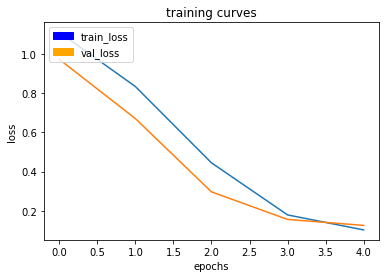

30/30 [==============================] - 22s - loss: 0.1026 - val_loss: 0.1255
Epoch 6/50
29/30 [============================>.] - ETA: 0s - loss: 0.0797

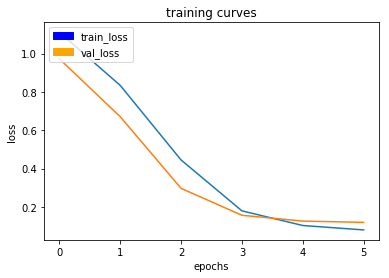

30/30 [==============================] - 21s - loss: 0.0795 - val_loss: 0.1189
Epoch 7/50
29/30 [============================>.] - ETA: 0s - loss: 0.0706

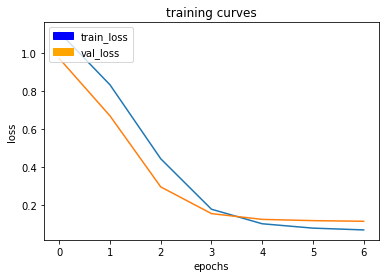

30/30 [==============================] - 22s - loss: 0.0704 - val_loss: 0.1155
Epoch 8/50
29/30 [============================>.] - ETA: 0s - loss: 0.0668

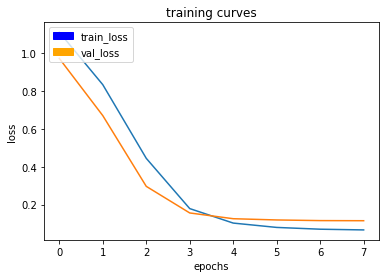

30/30 [==============================] - 23s - loss: 0.0663 - val_loss: 0.1149
Epoch 9/50
29/30 [============================>.] - ETA: 0s - loss: 0.0586

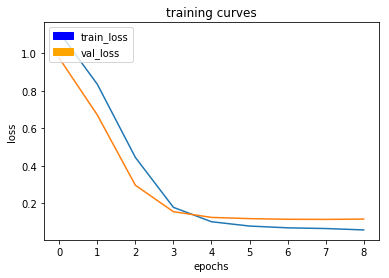

30/30 [==============================] - 22s - loss: 0.0588 - val_loss: 0.1166
Epoch 10/50
29/30 [============================>.] - ETA: 0s - loss: 0.0574

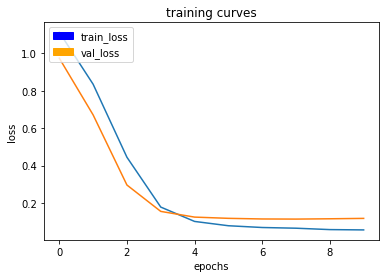

30/30 [==============================] - 22s - loss: 0.0572 - val_loss: 0.1187
Epoch 11/50
29/30 [============================>.] - ETA: 0s - loss: 0.0520

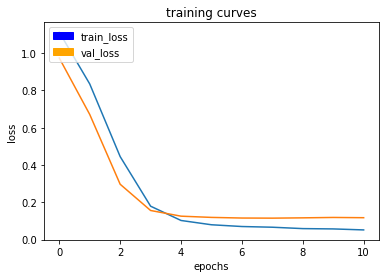

30/30 [==============================] - 22s - loss: 0.0518 - val_loss: 0.1173
Epoch 12/50
29/30 [============================>.] - ETA: 0s - loss: 0.0484

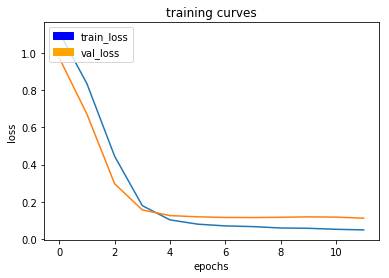

30/30 [==============================] - 22s - loss: 0.0485 - val_loss: 0.1115
Epoch 13/50
29/30 [============================>.] - ETA: 0s - loss: 0.0493

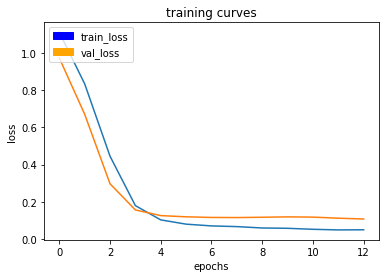

30/30 [==============================] - 21s - loss: 0.0493 - val_loss: 0.1071
Epoch 14/50
29/30 [============================>.] - ETA: 0s - loss: 0.0496

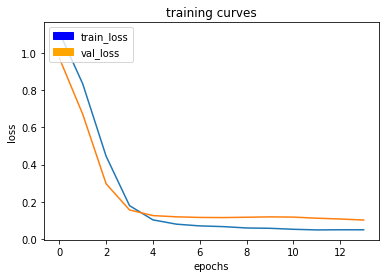

30/30 [==============================] - 22s - loss: 0.0492 - val_loss: 0.1016
Epoch 15/50
29/30 [============================>.] - ETA: 0s - loss: 0.0437

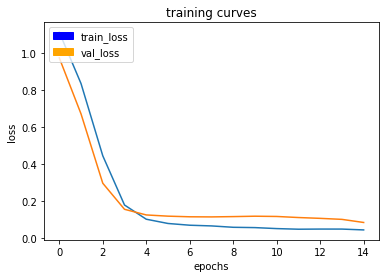

30/30 [==============================] - 22s - loss: 0.0447 - val_loss: 0.0849
Epoch 16/50
29/30 [============================>.] - ETA: 0s - loss: 0.0437

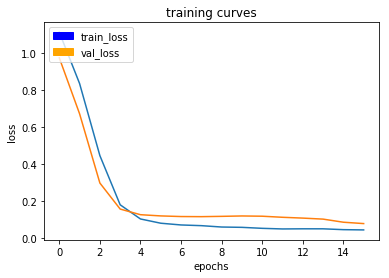

30/30 [==============================] - 23s - loss: 0.0434 - val_loss: 0.0775
Epoch 17/50
29/30 [============================>.] - ETA: 0s - loss: 0.0428

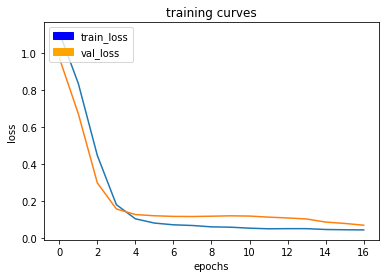

30/30 [==============================] - 22s - loss: 0.0424 - val_loss: 0.0679
Epoch 18/50
29/30 [============================>.] - ETA: 0s - loss: 0.0423

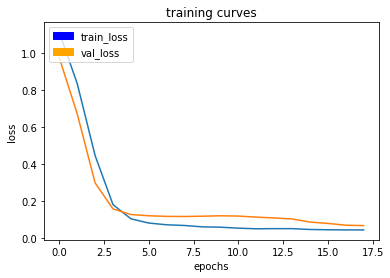

30/30 [==============================] - 22s - loss: 0.0422 - val_loss: 0.0657
Epoch 19/50
29/30 [============================>.] - ETA: 0s - loss: 0.0387

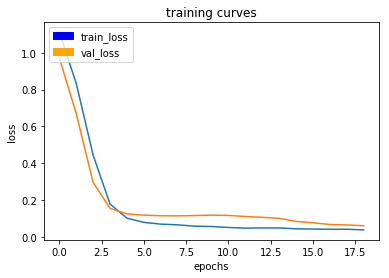

30/30 [==============================] - 22s - loss: 0.0386 - val_loss: 0.0613
Epoch 20/50
29/30 [============================>.] - ETA: 0s - loss: 0.0440

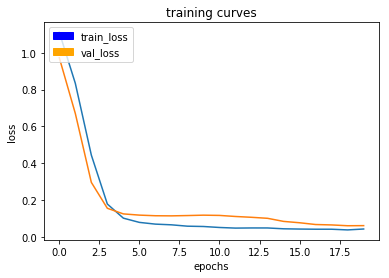

30/30 [==============================] - 22s - loss: 0.0439 - val_loss: 0.0618
Epoch 21/50
29/30 [============================>.] - ETA: 0s - loss: 0.0403

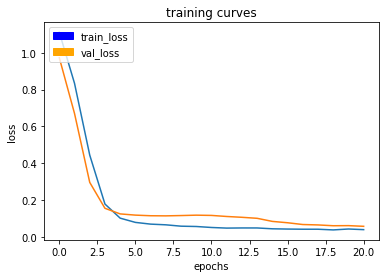

30/30 [==============================] - 22s - loss: 0.0401 - val_loss: 0.0582
Epoch 22/50
29/30 [============================>.] - ETA: 0s - loss: 0.0382

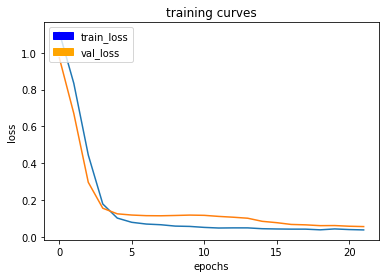

30/30 [==============================] - 22s - loss: 0.0381 - val_loss: 0.0562
Epoch 23/50
29/30 [============================>.] - ETA: 0s - loss: 0.0383

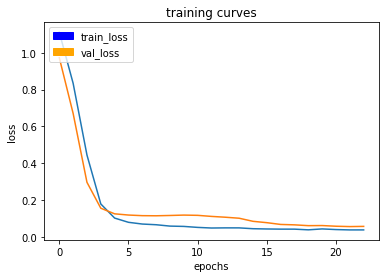

30/30 [==============================] - 22s - loss: 0.0382 - val_loss: 0.0573
Epoch 24/50
29/30 [============================>.] - ETA: 0s - loss: 0.0402

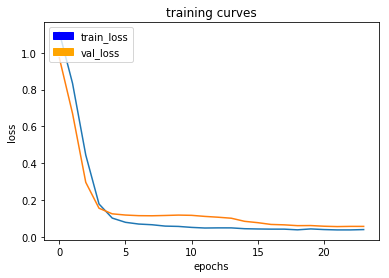

30/30 [==============================] - 21s - loss: 0.0399 - val_loss: 0.0573
Epoch 25/50
29/30 [============================>.] - ETA: 0s - loss: 0.0393

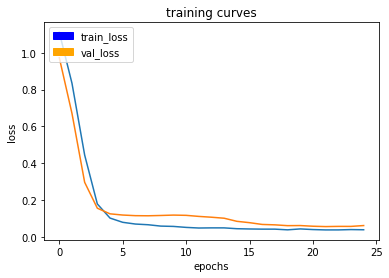

30/30 [==============================] - 22s - loss: 0.0390 - val_loss: 0.0619
Epoch 26/50
29/30 [============================>.] - ETA: 0s - loss: 0.0364

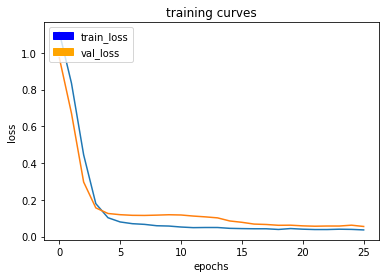

30/30 [==============================] - 22s - loss: 0.0364 - val_loss: 0.0548
Epoch 27/50
29/30 [============================>.] - ETA: 0s - loss: 0.0369

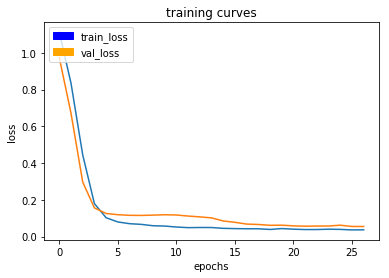

30/30 [==============================] - 22s - loss: 0.0367 - val_loss: 0.0548
Epoch 28/50
29/30 [============================>.] - ETA: 0s - loss: 0.0348

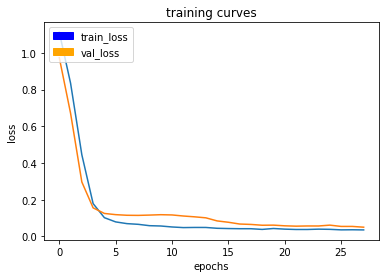

30/30 [==============================] - 22s - loss: 0.0358 - val_loss: 0.0506
Epoch 29/50
29/30 [============================>.] - ETA: 0s - loss: 0.0355

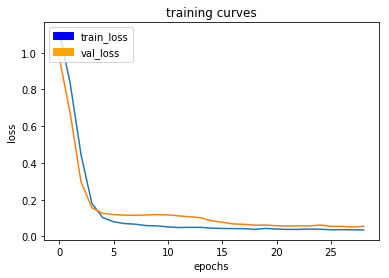

30/30 [==============================] - 21s - loss: 0.0353 - val_loss: 0.0548
Epoch 30/50
29/30 [============================>.] - ETA: 0s - loss: 0.0374

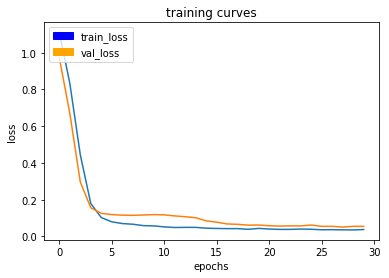

30/30 [==============================] - 22s - loss: 0.0374 - val_loss: 0.0547
Epoch 31/50
29/30 [============================>.] - ETA: 0s - loss: 0.0374

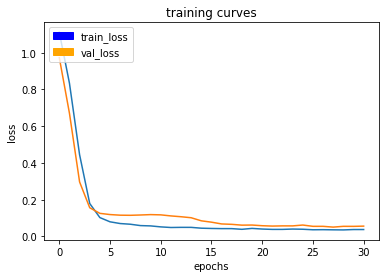

30/30 [==============================] - 22s - loss: 0.0375 - val_loss: 0.0559
Epoch 32/50
29/30 [============================>.] - ETA: 0s - loss: 0.0331

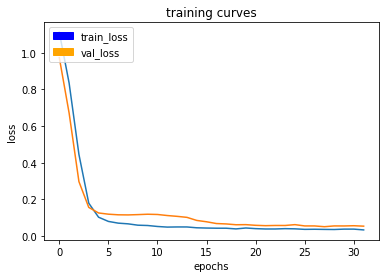

30/30 [==============================] - 22s - loss: 0.0331 - val_loss: 0.0535
Epoch 33/50
29/30 [============================>.] - ETA: 0s - loss: 0.0351

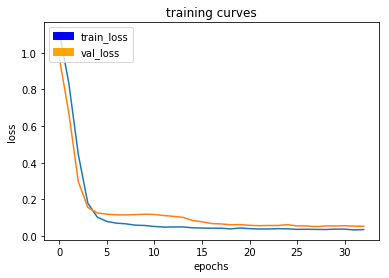

30/30 [==============================] - 21s - loss: 0.0351 - val_loss: 0.0531
Epoch 34/50
29/30 [============================>.] - ETA: 0s - loss: 0.0331

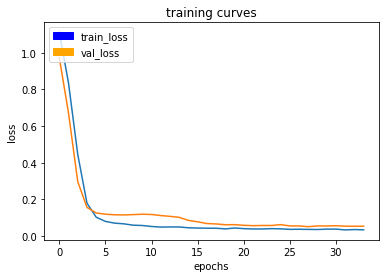

30/30 [==============================] - 22s - loss: 0.0335 - val_loss: 0.0532
Epoch 35/50
29/30 [============================>.] - ETA: 0s - loss: 0.0320

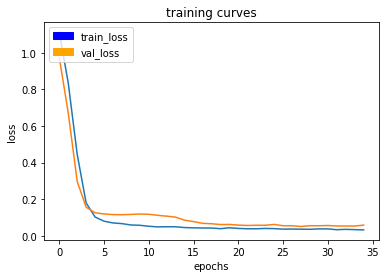

30/30 [==============================] - 21s - loss: 0.0318 - val_loss: 0.0580
Epoch 36/50
29/30 [============================>.] - ETA: 0s - loss: 0.0356

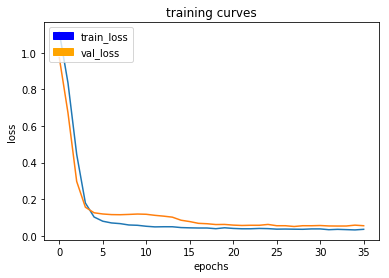

30/30 [==============================] - 22s - loss: 0.0352 - val_loss: 0.0548
Epoch 37/50
29/30 [============================>.] - ETA: 0s - loss: 0.0321

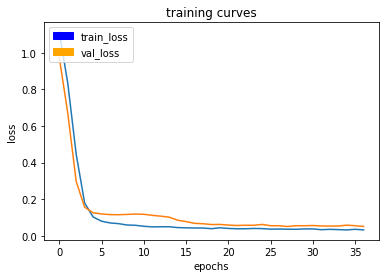

30/30 [==============================] - 21s - loss: 0.0321 - val_loss: 0.0508
Epoch 38/50
29/30 [============================>.] - ETA: 0s - loss: 0.0311

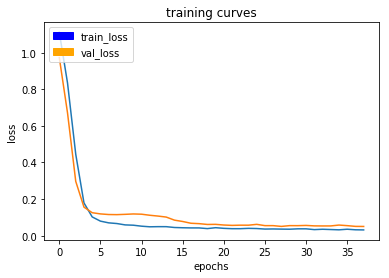

30/30 [==============================] - 22s - loss: 0.0314 - val_loss: 0.0503
Epoch 39/50
29/30 [============================>.] - ETA: 0s - loss: 0.0349

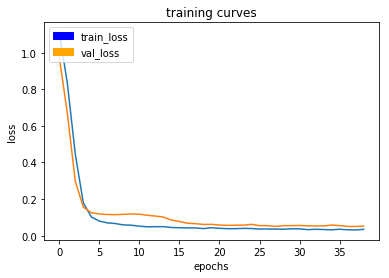

30/30 [==============================] - 22s - loss: 0.0346 - val_loss: 0.0522
Epoch 40/50
29/30 [============================>.] - ETA: 0s - loss: 0.0343

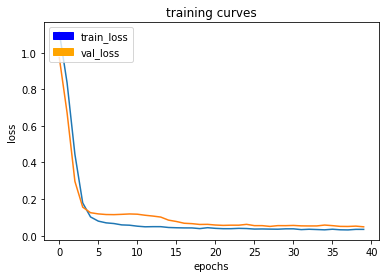

30/30 [==============================] - 22s - loss: 0.0344 - val_loss: 0.0484
Epoch 41/50
29/30 [============================>.] - ETA: 0s - loss: 0.0305

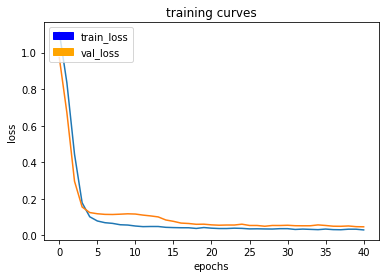

30/30 [==============================] - 21s - loss: 0.0305 - val_loss: 0.0475
Epoch 42/50
29/30 [============================>.] - ETA: 0s - loss: 0.0309

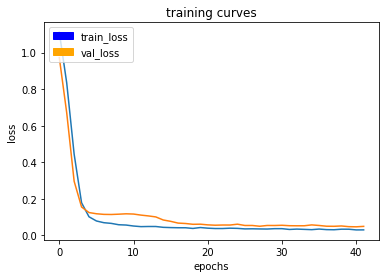

30/30 [==============================] - 21s - loss: 0.0308 - val_loss: 0.0499
Epoch 43/50
29/30 [============================>.] - ETA: 0s - loss: 0.0330

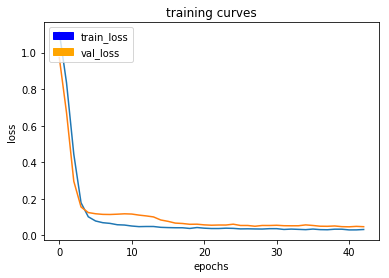

30/30 [==============================] - 21s - loss: 0.0329 - val_loss: 0.0481
Epoch 44/50
29/30 [============================>.] - ETA: 0s - loss: 0.0329

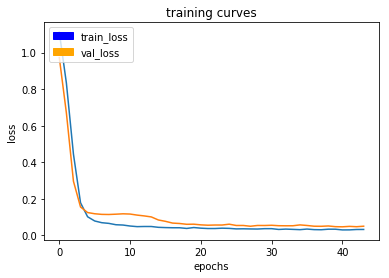

30/30 [==============================] - 21s - loss: 0.0330 - val_loss: 0.0508
Epoch 45/50
29/30 [============================>.] - ETA: 0s - loss: 0.0293

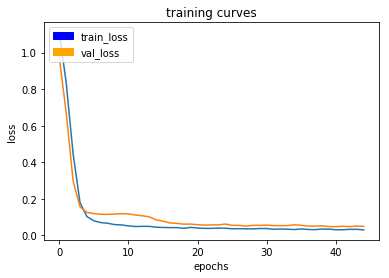

30/30 [==============================] - 22s - loss: 0.0298 - val_loss: 0.0490
Epoch 46/50
29/30 [============================>.] - ETA: 0s - loss: 0.0309

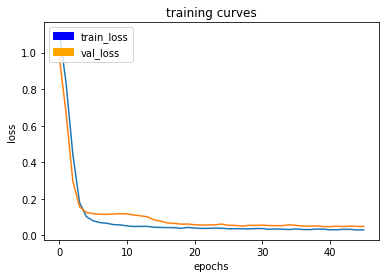

30/30 [==============================] - 21s - loss: 0.0306 - val_loss: 0.0490
Epoch 47/50
29/30 [============================>.] - ETA: 0s - loss: 0.0333

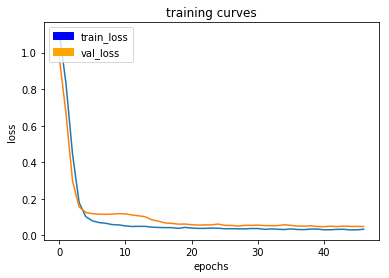

30/30 [==============================] - 22s - loss: 0.0334 - val_loss: 0.0485
Epoch 48/50
29/30 [============================>.] - ETA: 0s - loss: 0.0298

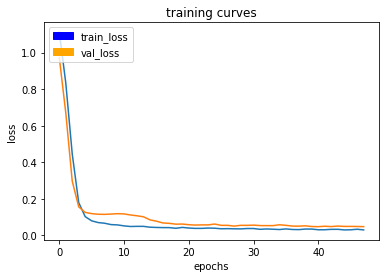

30/30 [==============================] - 21s - loss: 0.0297 - val_loss: 0.0476
Epoch 49/50
29/30 [============================>.] - ETA: 0s - loss: 0.0280

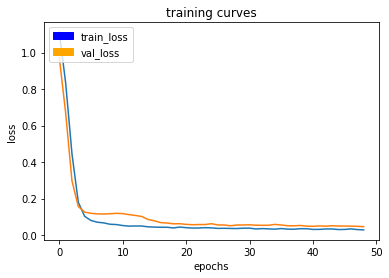

30/30 [==============================] - 22s - loss: 0.0278 - val_loss: 0.0454
Epoch 50/50
29/30 [============================>.] - ETA: 0s - loss: 0.0320

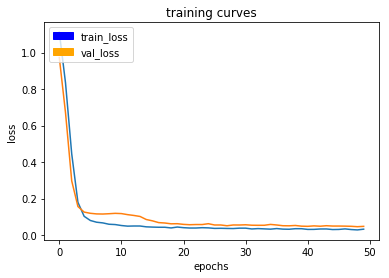

30/30 [==============================] - 21s - loss: 0.0318 - val_loss: 0.0473
Wall time: 18min 34s


In [103]:
%%time
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [105]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction<a id='prediction'></a>

In [106]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

In [107]:
# generate predictions, save in the runs, directory.
run_number = 'run1'
validation_path, output_path = model_tools.write_predictions_grade_set(model,run_number,'validation')

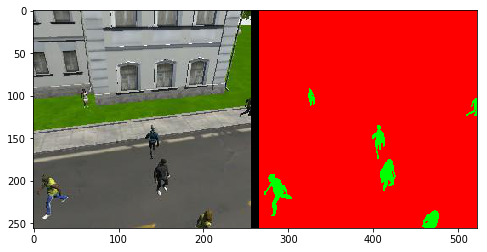

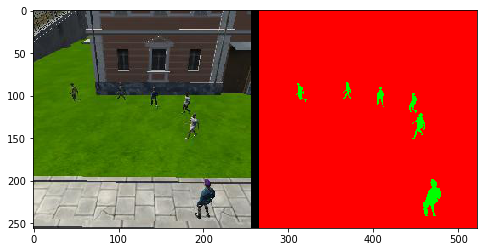

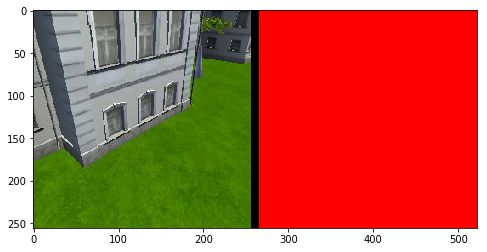

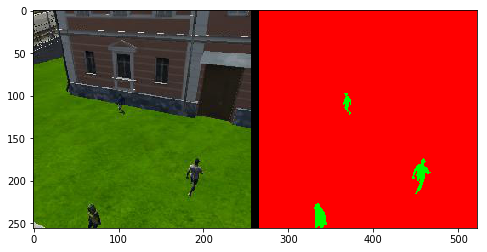

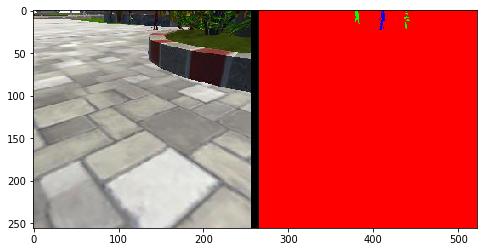

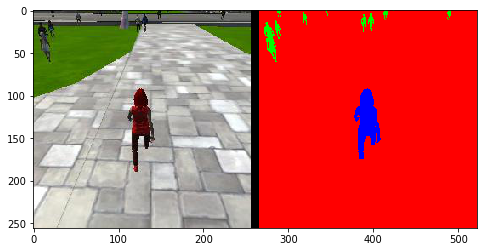

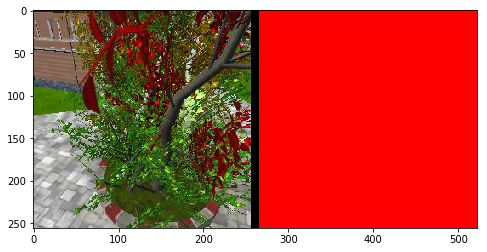

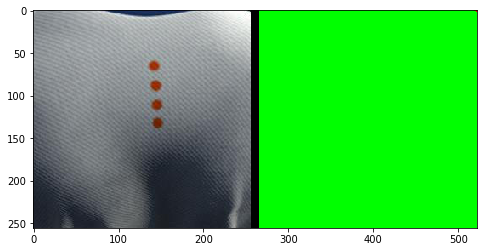

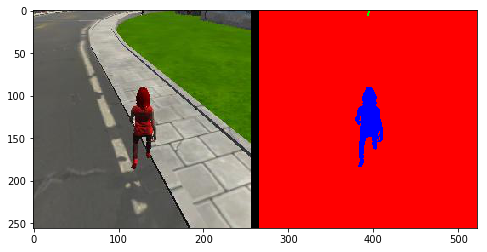

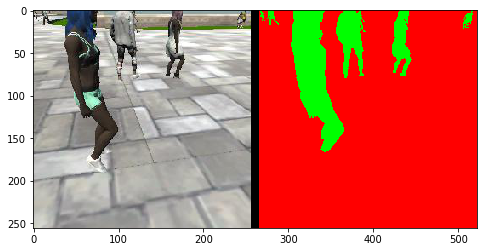

In [113]:
# take a look at predictions
# validation_path = 'validation'
im_files = plotting_tools.get_im_file_sample(run_number,validation_path) 
for i in range(10):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation<a id='evaluation'></a>
Let's evaluate your model!

In [114]:
scoring_utils.score_run(validation_path, output_path)

number of validation samples intersection over the union evaulated on 1184
average intersection over union for background is 0.9899600490953762
average intersection over union for other people is 0.242000973701431
average intersection over union for hero is 0.1321114923949302
global average intersection over union is 0.45469083839724583
